In [1]:
import os
import sys
import cv2
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        super(Classifier, self).__init__()

        self.linear1 = nn.Linear(in_f, 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, out_f)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class New_head(torch.nn.Module):
    def __init__(self, in_f):
        super(New_head, self).__init__()
        self.ln = nn.Linear(in_f, 512)
        self.act = nn.ReLU()
        self.out = nn.Linear(512, 1)

    def forward(self, x):
        x = self.ln(x)
        x = self.act(x)
        x = self.out(x)
        return x

class FCN(torch.nn.Module):
    def __init__(self, base):
        super(FCN, self).__init__()
        self.base = base
        self.cf = New_head(1000)

    def forward(self, x):
        x = self.base(x)
        return self.cf(x)

In [3]:
import timm

model_names = [
    'efficientnet_b1',
    'efficientnet_b3',
    'efficientnet_b5',
    'vit_base_patch16_224',
    'resnext50_32x4d',
    'resnext101_32x4d',
    'convnext_tiny.in12k_ft_in1k_384'
]

score_valid = {
    'efficientnet_b1': 0.87792,
    'efficientnet_b3': 0.87978,
    'efficientnet_b5': 0.89640,
    'vit_base_patch16_224': 0.8784,
    'resnext50_32x4d': 0.859,
    'resnext101_32x4d': 0.88269,
    'convnext_tiny.in12k_ft_in1k_384' : 0.877224
}

net = []

for name in model_names:
    if 'convnext' in name:
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384', pretrained=False)
        model = FCN(model)
        net.append(model)
        continue

    model = timm.create_model(
        name,
        pretrained=False,
        num_classes=1
    )
    
    if "efficient" in name:
        model.classifier = Classifier(model.classifier.in_features, 1)
    net.append(model)

In [4]:
import torch

net[0].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/effb1/model_26.pth'))
net[1].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/effb3/model_19.pth'))
net[2].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/effb5/model_27.pth'))
net[3].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/vit/model_20.pth'))
net[4].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/resnext/resnext/resnext-50.pth'))
net[5].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/resnext/resnext/resnext-101.pth'))
net[6].load_state_dict(torch.load('/kaggle/input/checkpoint-dfdc/convnext/kaggle/working/model_3.pth')) # .410

for i in range(len(net)):
    net[i] = net[i].to(device)

In [5]:
import sys
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import time
import tensorflow as tf
import numpy as np
import glob
from tqdm import tqdm

detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('../input/mobilenet-face/frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

def get_mobilenet_face(image):
    global boxes,scores,num_detections
    (im_height,im_width)=image.shape[:-1]
    imgs=np.array([image])
    (boxes, scores) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    max_=np.where(scores==scores.max())[0][0]
    box=boxes[0][max_]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    return (left, right, top, bottom)

def crop_image(frame,bbox):
    left, right, top, bottom=bbox
    return frame[top:bottom,left:right]

def get_img(frame):
    return cv2.resize(crop_image(frame,get_mobilenet_face(frame)),(160,160))

def detect_video(video, frame_count=30):
    capture = cv2.VideoCapture(video)
    v_len = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0,v_len,frame_count, endpoint=False, dtype=int)
    imgs=[]
    i=0
    for frame_idx in range(int(v_len)):
        ret = capture.grab()
        if not ret: 
            pass
        if frame_idx >= frame_idxs[i]:
            ret, frame = capture.retrieve()
            if not ret or frame is None:
                pass
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                try:
                    face=get_img(frame)
                except Exception as err:
                    print(err)
                    continue
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                imgs.append(face)
            i += 1
            if i >= len(frame_idxs):
                break
    if len(imgs)<frame_count:
        return None
    return imgs

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prediction loop

In [6]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [7]:
def confident_strategy(pred, t=0.8):
    pred = np.array(pred)
    return np.mean(pred)

In [8]:
from os import listdir
from os.path import isfile, join

In [9]:
def get_predict(model):
    correct = 0
    all_probs = []
    for type_data in ['fAkE', 'ReAl']:
        mypath = f'/kaggle/input/deepfake-video/Hehe-final/Data/{type_data}'
        files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

        for file in files:
            video_path = f'/kaggle/input/deepfake-video/Hehe-final/Data/{type_data}/' + file
            faces_ = detect_video(video_path, frame_count=25)
            inputs = []
            faces = []

            for face in faces_:
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                img = np.rollaxis(cv2.resize(face, (224, 224)), -1, 0)
                faces.append(img)

            faces = torch.from_numpy(np.array(faces)).float().to(device)

            probs = []
            with torch.no_grad():
                model.eval()
                probs_ = []
                for i, face in enumerate(faces):
                    face = normalize_transform(face / 255.)
                    face = face.unsqueeze(dim=0)
                    face = face.to(device)
                    out = model(face)
                    out = torch.sigmoid(out.squeeze())
                    probs_.append(out.item())
                probs = confident_strategy(probs_)
            if probs >= 0.5 and type_data == 'fAkE':
                correct += 1.0
            elif probs < 0.5 and type_data == 'ReAl':
                correct += 1.0
            all_probs.append(probs)
            
    print(correct)
    return all_probs

In [10]:
all_probs = []
for i in tqdm(range(len(net))):
    prob = get_predict(net[i])
    all_probs.append(prob)

 14%|█▍        | 1/7 [02:21<14:08, 141.43s/it]

75.0


 29%|██▊       | 2/7 [04:37<11:32, 138.56s/it]

69.0


 43%|████▎     | 3/7 [07:14<09:46, 146.67s/it]

69.0


 57%|█████▋    | 4/7 [09:22<06:57, 139.26s/it]

75.0


 71%|███████▏  | 5/7 [11:28<04:29, 134.59s/it]

70.0


 86%|████████▌ | 6/7 [13:52<02:17, 137.69s/it]

65.0


100%|██████████| 7/7 [15:50<00:00, 135.76s/it]

71.0


In [11]:
prob_ensemble = np.sum([[e * 0.4 for e in all_probs[0]] , [e *  0.6 for e in all_probs[3]]], axis=0)

In [12]:
def result(prob):
    score = np.array(prob)
    true = np.concatenate((np.ones(50), np.zeros(50)))

    print('Log Loss: {:.4f}'.format(log_loss(y_pred=score, y_true=true)))
    print('Roc Auc: {:.4f}'.format(roc_auc_score(y_score=score, y_true=true)))

    score[score >= 0.5] = 1
    score[score < 0.5] = 0

    print('Classification Report')
    print('===' * 20)
    print(classification_report(y_pred=score, y_true=true))

In [13]:
from sklearn.metrics import log_loss, classification_report, roc_auc_score

for i in range(len(model_names)):
    print(f'\n----------------------------- {model_names[i].upper()} -----------------------------------')
    result(all_probs[i])


----------------------------- EFFICIENTNET_B1 -----------------------------------
Log Loss: 0.6201
Roc Auc: 0.8236
Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79        50
         1.0       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100


----------------------------- EFFICIENTNET_B3 -----------------------------------
Log Loss: 0.8214
Roc Auc: 0.8096
Classification Report
              precision    recall  f1-score   support

         0.0       0.62      0.98      0.76        50
         1.0       0.95      0.40      0.56        50

    accuracy                           0.69       100
   macro avg       0.79      0.69      0.66       100
weighted avg       0.79      0.69      0.66       100


----------------------------- EFFICIENTNET_B5 -----------------------

In [14]:
print(f'\n----------------------------- ENSEMBLE -----------------------------------')
result(prob_ensemble)


----------------------------- ENSEMBLE -----------------------------------
Log Loss: 0.4623
Roc Auc: 0.8640
Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        50
         1.0       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



(array([3., 5., 4., 3., 2., 2., 1., 2., 2., 3., 2., 3., 4., 0., 2., 2., 2.,
        4., 2., 1., 5., 1., 4., 5., 0., 1., 4., 2., 0., 2., 2., 3., 3., 2.,
        5., 2., 2., 2., 1., 5.]),
 array([0.00510505, 0.02891818, 0.05273131, 0.07654444, 0.10035756,
        0.12417069, 0.14798382, 0.17179695, 0.19561007, 0.2194232 ,
        0.24323633, 0.26704946, 0.29086258, 0.31467571, 0.33848884,
        0.36230197, 0.38611509, 0.40992822, 0.43374135, 0.45755448,
        0.4813676 , 0.50518073, 0.52899386, 0.55280699, 0.57662011,
        0.60043324, 0.62424637, 0.6480595 , 0.67187262, 0.69568575,
        0.71949888, 0.74331201, 0.76712513, 0.79093826, 0.81475139,
        0.83856452, 0.86237764, 0.88619077, 0.9100039 , 0.93381703,
        0.95763016]),
 <BarContainer object of 40 artists>)

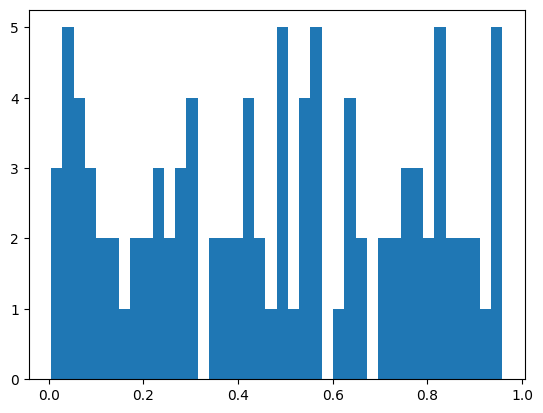

In [15]:
plt.hist(prob_ensemble, 40)

## DEMO

In [16]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    
    html += '<div style="display: flex; justify-content: center; align-items: center; height: 100vh;">'
    html += '<video width="200" controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    html += '</div>'
    
    return HTML(html)

def get_predict_ensemble(models, file):
    res = {}
    video_path = file
    faces_ = detect_video(video_path, frame_count=25)
    inputs = []
    faces = []

    for face in faces_:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        img = np.rollaxis(cv2.resize(face, (224, 224)), -1, 0)
        faces.append(img)

    faces = torch.from_numpy(np.array(faces)).float().to(device)

    probs = []
    with torch.no_grad():
        for model in models:
            model.eval()
            probs_ = []
            for i, face in enumerate(faces):
                face = normalize_transform(face / 255.)
                face = face.unsqueeze(dim=0)
                face = face.to(device)
                out = model(face)
                out = torch.sigmoid(out.squeeze())
                probs_.append(out.item())
            probs.append(confident_strategy(probs_))

        res[file.split('/')[-1]] = probs[0] * 0.4 + probs[1] * 0.6
            
    return file.split('/')[-1], res[file.split('/')[-1]]

In [17]:
videos = [
    '/kaggle/input/deepfake-video/fake/thanh.mp4',
    '/kaggle/input/deepfake-video/fake/my_1.mp4',
    '/kaggle/input/deepfake-video/fake/duy.mp4',
]

play(videos[2])

In [18]:
for video in videos:
    name, res = get_predict_ensemble([net[0], net[3]], video)
    print(name, res)

thanh.mp4 0.7258913539648055
my_1.mp4 0.6304840857870877
duy.mp4 0.5715705890953541
